In [14]:
%run './model/multi_corpus.py'
%run './constants.py'

from scipy.cluster.hierarchy import linkage, dendrogram

from matplotlib import cm

from itertools import combinations

In [51]:
corpora = co_citation_graphs()
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 439 nodes and 810 edges
Geometry Graph with 298 nodes and 388 edges
Geophysics Graph with 16305 nodes and 82952 edges
Economics Graph with 4278 nodes and 53161 edges
Language & Linguistics Graph with 1270 nodes and 7819 edges
Probability & Statistics Graph with 1805 nodes and 8151 edges
Material Engineering Graph with 19577 nodes and 213117 edges
Artificial Intelligence Graph with 1897 nodes and 9012 edges
Sociology Graph with 2327 nodes and 21230 edges
International Business Graph with 2667 nodes and 39483 edges
Political Science Graph with 2442 nodes and 13314 edges
Genetics & Genomics Graph with 9323 nodes and 55121 edges
Immunology Graph with 12636 nodes and 190468 edges
Human Resources & Organizations Graph with 3063 nodes and 24554 edges
Ethnic & Cultural Studies Graph with 310 nodes and 506 edges
Neurology Graph with 18589 nodes and 270528 edges


In [105]:
field_name = 'Sociology'

G = Gs[field_name]
df = Dfs[field_name]

In [106]:
comms = nx.community.louvain_communities(G)
comms_dict = {n: i for i, comm in enumerate(comms) for n in comm}
nx.set_node_attributes(G, comms_dict, 'Community')

In [107]:
def aggregate_graph(G, attr):
    H = nx.Graph()

    community_edge_weights = {}
    community_sizes = {}

    for node, data in G.nodes(data=True):
        community = data[attr]
        if community not in H:
            H.add_node(community, size=1)
            community_sizes[community] = 1
        else:
            H.nodes[community]["size"] += 1
            community_sizes[community] += 1

        for neighbor in G.neighbors(node):
            neighbor_community = G.nodes[neighbor][attr]
            if neighbor_community == community:
                H.add_edge(community, community)
            else:
                if (community, neighbor_community) not in community_edge_weights:
                    community_edge_weights[(community, neighbor_community)] = 0
                community_edge_weights[(community, neighbor_community)] += 1

    for (community_i, community_j), weight in community_edge_weights.items():
        H.add_edge(community_i, community_j, weight=weight)
    
    return H

In [108]:
G = aggregate_graph(G, 'Community')

In [113]:
for u, v, d in G.edges(data=True):
    print(u, v, d)

0 0 {}
0 7 {'weight': 382}
0 3 {'weight': 36}
0 10 {'weight': 70}
0 2 {'weight': 154}
0 5 {'weight': 17}
0 8 {'weight': 95}
0 12 {'weight': 88}
0 1 {'weight': 19}
0 4 {'weight': 31}
0 11 {'weight': 4}
0 9 {'weight': 3}
2 2 {}
2 11 {'weight': 80}
2 7 {'weight': 335}
2 10 {'weight': 402}
2 1 {'weight': 377}
2 3 {'weight': 28}
2 5 {'weight': 98}
2 12 {'weight': 85}
2 8 {'weight': 128}
2 4 {'weight': 91}
2 9 {'weight': 1}
10 10 {}
10 7 {'weight': 245}
10 8 {'weight': 188}
10 5 {'weight': 118}
10 1 {'weight': 234}
10 12 {'weight': 106}
10 3 {'weight': 72}
10 11 {'weight': 44}
10 4 {'weight': 82}
10 9 {'weight': 3}
1 1 {}
1 4 {'weight': 221}
1 3 {'weight': 179}
1 5 {'weight': 53}
1 7 {'weight': 177}
1 11 {'weight': 141}
1 8 {'weight': 63}
1 12 {'weight': 78}
4 4 {}
4 7 {'weight': 190}
4 12 {'weight': 54}
4 3 {'weight': 59}
4 5 {'weight': 28}
4 11 {'weight': 26}
4 8 {'weight': 23}
7 7 {}
7 3 {'weight': 195}
7 12 {'weight': 330}
7 8 {'weight': 189}
7 5 {'weight': 52}
7 9 {'weight': 7}
7 11 {'w

In [111]:
node_sizes = {n: d['size'] * 50 for n, d in G.nodes(data=True)}
nodelist = list(node_sizes.keys())
node_size = list(node_sizes.values())

edge_sizes = {(u, v): d['weight'] * 50 for u, v, d in G.edges(data=True)}
edgelist = list(edge_sizes.keys())
edge_size = list(edge_sizes.values())


KeyError: 'weight'

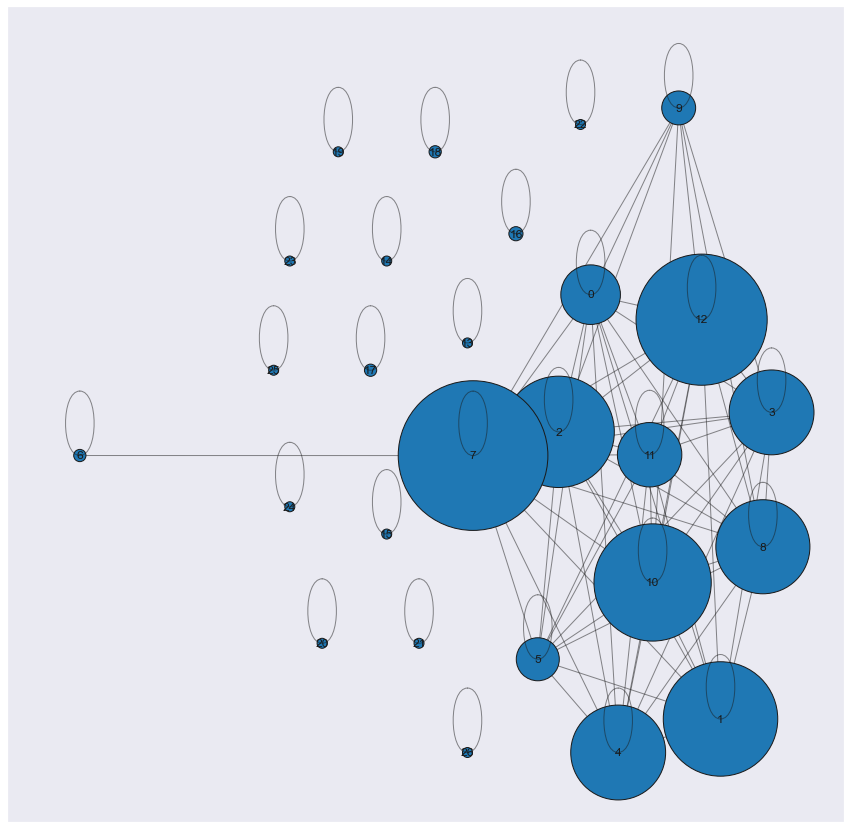

In [117]:
fig, ax = plt.subplots(1, figsize=(15, 15))

pos = nx.nx_agraph.graphviz_layout(G, prog='sfdp') # dot, twopi, fdp, sfdp, circo

nx.draw_networkx_nodes(
    G, 
    pos,
    nodelist=nodelist,
    node_size=node_size,
    # node_color='#00ABB3',
    # node_color=node_color,
    node_shape='o',
    alpha=None,
    cmap=plt.cm.Blues,
    ax=ax,
    linewidths=1.0,
    edgecolors='k',
).set_zorder(1)

nx.draw_networkx_labels(G, pos=pos, ax=ax, labels=dict(zip(nodelist, nodelist)))

nx.draw_networkx_edges(
    G, 
    pos,
    width=1.0,
    edge_color='k',
    style='solid',
    alpha=0.5,
    arrowsize=10,
    ax=ax,
    nodelist=nodelist,
    node_size=node_size,
    node_shape='o',
    connectionstyle='arc3',
    # width=width,
).set_zorder(-1)

ax.grid(False)

plt.show()
# plt.savefig(
#     os.path.join(LATEX_FIGURES_PATH, 'co_occurrence_graphs', f'{field_name.capitalize()}.png'), 
#     transparent=True, 
#     dpi=150 
# )

In [260]:
df_comm = (
    pl.DataFrame([
        pl.Series('Doi', list(comms_dict.keys())),
        pl.Series('Community', list(comms_dict.values())),
    ])
    .join(df, on='Doi', how='left')
    .select(
        pl.col('Doi'), 
        pl.col('Community'), 
        pl.col('Text'),
    )
    .groupby('Community')
    .agg(
        pl.col('Doi'), 
        pl.col('Text')
    )
    .with_columns(
        pl.col('Text')
        .arr.eval(pl.element().explode())
    )
)
df_comm

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_2797/2685916658.py:19: DeprecationWarning: `Series/Expr.explode()` is deprecated in favor of the identical method under the list and string namespaces. Use `.arr.explode()` or `.str.explode()` instead.
  .arr.eval(pl.element().explode())


Community,Doi,Text
i64,list[str],list[str]
16,"[""10.1177/0049124112460374"", ""10.1177/0049124101030001003"", ... ""10.1093/sf/sor006""]","[""panel"", ""conditioning"", ... ""issue""]"
24,"[""10.1177/0003122412447793"", ""10.1093/sf/sov069""]","[""segregation"", ""poverty"", ... ""deconcentration""]"
0,"[""10.1086/231212"", ""10.1086/231084"", ... ""10.1353/sof.2003.0085""]","[""impact"", ""cultural"", ... ""institution""]"
8,"[""10.1177/0003122414531776"", ""10.1177/0003122417705656"", ... ""10.1086/339225""]","[""social"", ""distance"", ... ""discussed""]"
23,"[""10.1146/annurev.soc.25.1.1"", ""10.1086/230702""]","[""sociology"", ""annual"", ... ""confront""]"
15,"[""10.1177/0003122412451728"", ""10.1353/sof.2007.0098""]","[""sexual"", ""harassment"", ... ""woman""]"
7,"[""10.1146/annurev.soc.34.040507.134627"", ""10.1177/000312240907400101"", ... ""10.1146/annurev.soc.32.061604.123106""]","[""broken"", ""race"", ... ""sibship""]"
22,"[""10.2307/3005545"", ""10.2307/2657441""]","[""educational"", ""personal"", ... ""record""]"
6,"[""10.1086/675386"", ""10.1086/595948"", ""10.1146/annurev-soc-071913-043229""]","[""saying"", ""yes"", ... ""sociology""]"


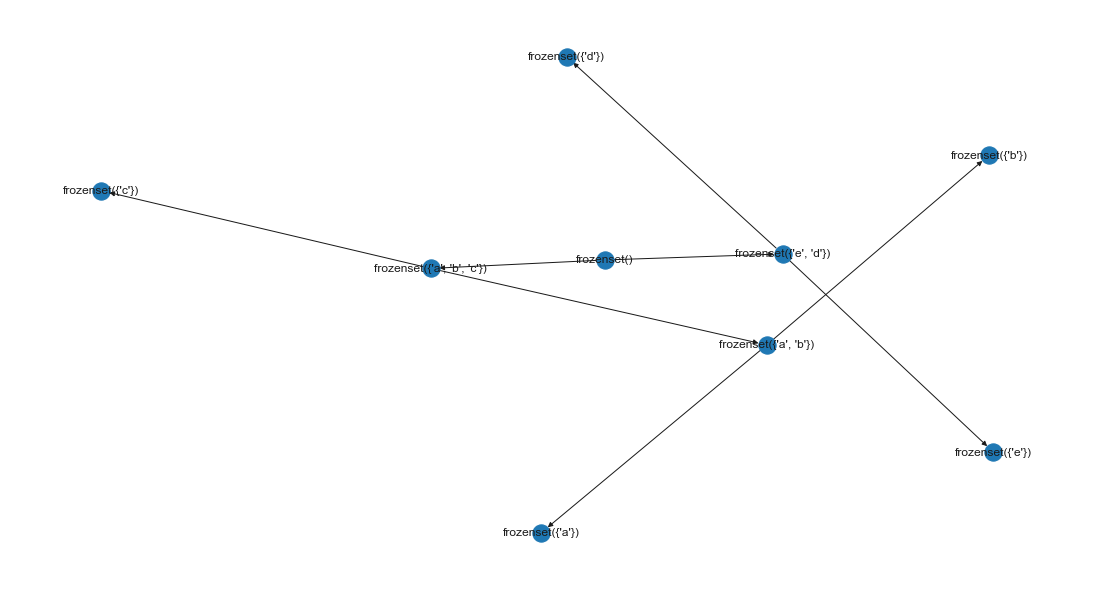

In [301]:
import networkx as nx

sets = [
    [{'a', 'b', 'c'}, {'d', 'e'}],
    [{'a', 'b'}, {'c'}, {'d', 'e'}],
    [{'a', 'b'}, {'c'}, {'d'}, {'e'}],
    [{'a'}, {'b'}, {'c'}, {'d'}, {'e'}],
]

n_levels = len(sets)
sets = list(reversed(sets))

G = nx.DiGraph()

for n in sets[-1]: G.add_edge(frozenset(), frozenset(n))

for i in range(n_levels-1):
    for child in sets[i]:
        for parent in sets[i+1]:
            if child.issubset(parent):
                G.add_edge(frozenset(parent), frozenset(child))

G.remove_edges_from(list(nx.selfloop_edges(G)))

nx.draw(G, with_labels=True)

# nodes = list(G.nodes)
# adj = nx.to_numpy_array(G)
# adj

In [303]:
descendants = nx.descendants_at_distance(G, frozenset(), 1)
n_descendants = len(descendants)

{frozenset({'d', 'e'}), frozenset({'a', 'b', 'c'})}

In [284]:
nodes = list(G.nodes)
d1 = dict(zip(nodes, range(len(nodes))))
d2 = {v: k for k, v in d1.items()}
d = d1 | d2
d

{frozenset(): 0,
 frozenset({'a', 'b', 'c'}): 1,
 frozenset({'d', 'e'}): 2,
 frozenset({'a', 'b'}): 3,
 frozenset({'c'}): 4,
 frozenset({'d'}): 5,
 frozenset({'e'}): 6,
 frozenset({'a'}): 7,
 frozenset({'b'}): 8,
 0: frozenset(),
 1: frozenset({'a', 'b', 'c'}),
 2: frozenset({'d', 'e'}),
 3: frozenset({'a', 'b'}),
 4: frozenset({'c'}),
 5: frozenset({'d'}),
 6: frozenset({'e'}),
 7: frozenset({'a'}),
 8: frozenset({'b'})}

In [287]:
leaves = [n for n in G.nodes if nx.degree(G, n) == 1]
leaves

[frozenset({'c'}),
 frozenset({'d'}),
 frozenset({'e'}),
 frozenset({'a'}),
 frozenset({'b'})]

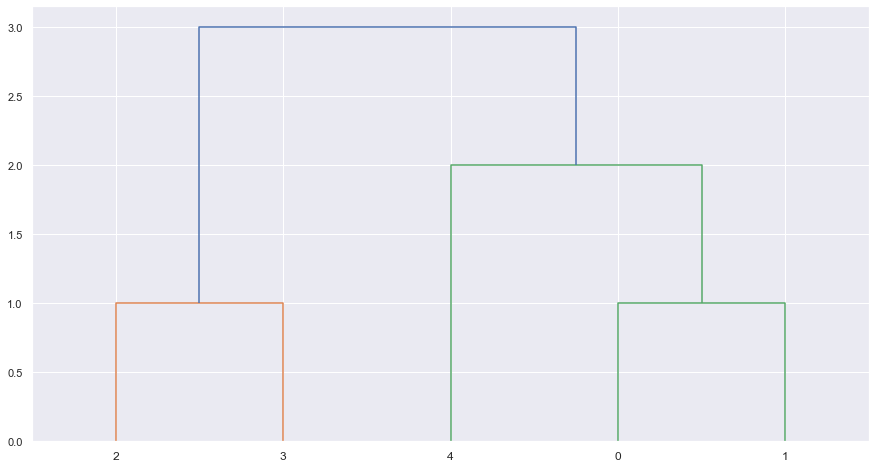

In [280]:
Z = [
    [0., 1., 1., 0.],
    [2., 3., 1., 0.],
    [4., 5., 2., 0.],
    [6., 7., 3., 0.],
]

dendrogram(Z)
plt.show()

In [258]:
shortest_path_lengths = nx.shortest_path_length(G, source=frozenset())
max_shortest_path_length = max(shortest_path_lengths.items(), key=lambda tup: tup[1])[1]
distances = {node: (max_shortest_path_length - shortest_path_length + 1) 
             for node, shortest_path_length in shortest_path_lengths.items()}
distances

{frozenset(): 4,
 frozenset({'d', 'e'}): 3,
 frozenset({'a', 'b', 'c'}): 3,
 frozenset({'a', 'b'}): 2,
 frozenset({'e'}): 2,
 frozenset({'d'}): 2,
 frozenset({'c'}): 2,
 frozenset({'a'}): 1,
 frozenset({'b'}): 1}

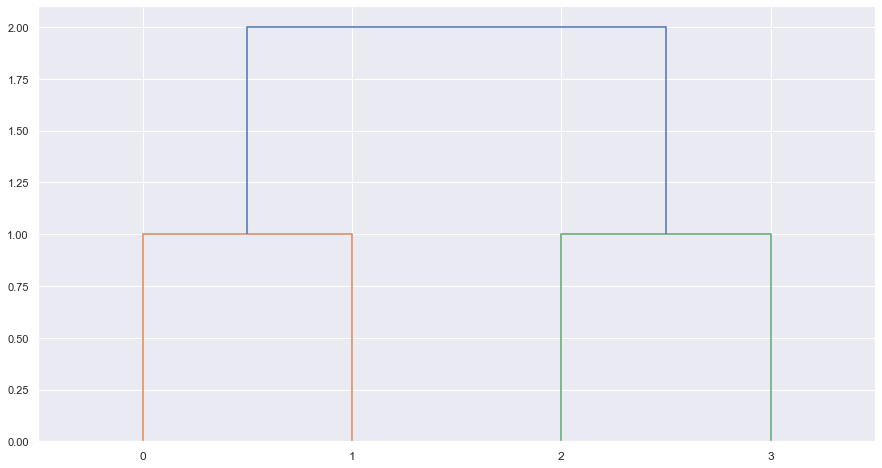

In [267]:
from scipy.cluster.hierarchy import dendrogram

sets = [
    [{'a', 'b'}, {'c', 'd'}],
    [{'a'}, {'b'}, {'c'}, {'d'}],
]

Z = [
    [0., 1., 1., 2.],
    [2., 3., 1., 2.],
    [4., 5., 2., 4.],
]

dendrogram(Z)
plt.show()

In [235]:
def transform_to_linkage(sets):
    Z = []

    for i, communities in enumerate(sets):
        num_communities = len(communities)
        for j in range(num_communities - 1):
            community1 = communities[j]
            community2 = communities[j + 1]
            Z.append([float(i), float(i + j + 1), 1.0, float(len(community1) + len(community2))])

    return Z

def transform_to_linkage(sets):
    Z = []
    cluster_index = 0

    for i, communities in enumerate(sets):
        num_communities = len(communities)
        for j in range(num_communities - 1):
            community1 = communities[j]
            community2 = communities[j + 1]
            merged_cluster = community1.union(community2)
            Z.append([float(cluster_index), float(cluster_index + 1), 1.0, float(len(merged_cluster))])
            cluster_index += 1

    return Z

# Example usage
sets = [
    [{'a', 'b'}, {'c', 'd'}],
    [{'a'}, {'b'}, {'c'}, {'d'}],
]

Z = transform_to_linkage(sets)
print(Z)


# Example usage
sets = [
    [{'a', 'b'}, {'c', 'd'}],
    [{'a'}, {'b'}, {'c'}, {'d'}],
]

Z = transform_to_linkage(sets)
print(Z)

dendrogram(Z)
plt.show()


[[0.0, 1.0, 1.0, 4.0], [1.0, 2.0, 1.0, 2.0], [2.0, 3.0, 1.0, 2.0], [3.0, 4.0, 1.0, 2.0]]
[[0.0, 1.0, 1.0, 4.0], [1.0, 2.0, 1.0, 2.0], [2.0, 3.0, 1.0, 2.0], [3.0, 4.0, 1.0, 2.0]]


ValueError: Linkage 'Z' uses the same cluster more than once.

In [172]:
import scipy

Z = scipy.cluster.hierarchy.linkage(adj)
Z

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_2797/1404483152.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = scipy.cluster.hierarchy.linkage(adj)


array([[ 5.        ,  6.        ,  0.        ,  2.        ],
       [ 7.        ,  8.        ,  0.        ,  2.        ],
       [ 0.        ,  4.        ,  1.        ,  2.        ],
       [ 9.        , 11.        ,  1.        ,  4.        ],
       [ 3.        , 12.        ,  1.41421356,  5.        ],
       [10.        , 13.        ,  1.41421356,  7.        ],
       [ 1.        , 14.        ,  1.41421356,  8.        ],
       [ 2.        , 15.        ,  2.        ,  9.        ]])

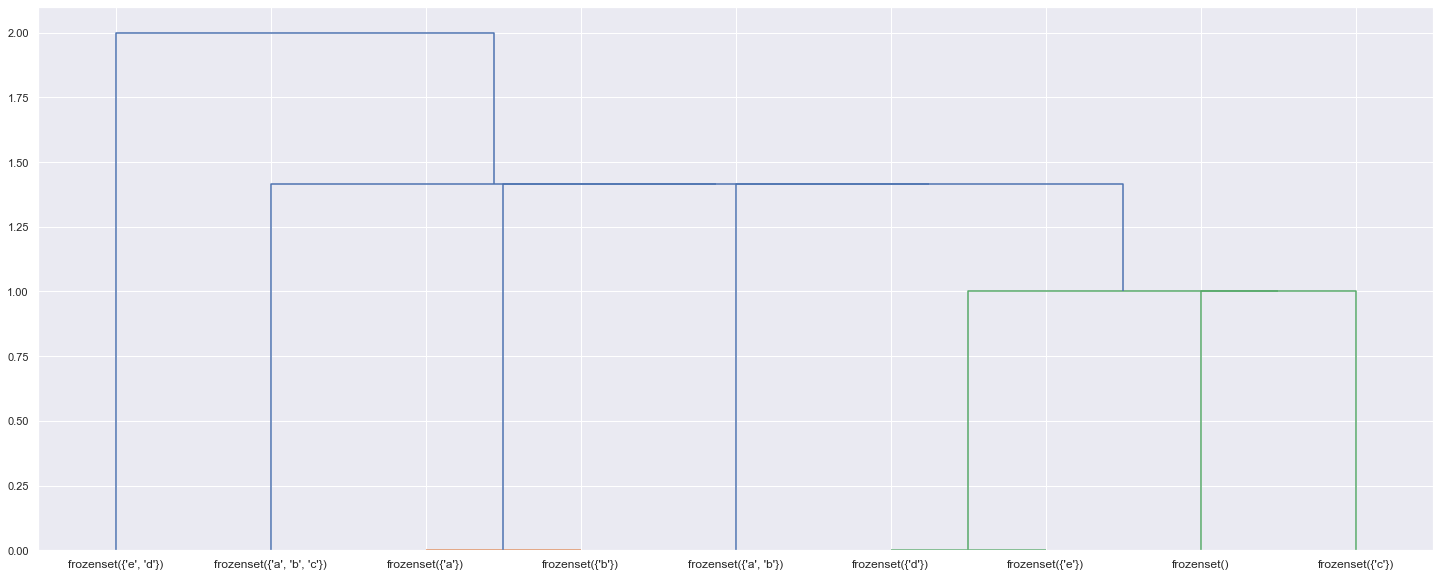

In [170]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels=nodes)
plt.show()

In [126]:
G = nx.karate_club_graph()

list(nx.community.girvan_newman(G))[0]

({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})

In [ ]:
from scipy.spatial.distance import squareform

condensed = squareform(adj)

In [120]:
import numpy as np
import networkx as nx

# Generate a test graph
G = nx.karate_club_graph()

# Run the Girvan-Newman algorithm
comp = nx.algorithms.community.girvan_newman(G)

# Extract the communities at each level of the dendrogram
communities = tuple(sorted(c) for c in next(comp))

# Compute the distance matrix between communities
n = len(communities)
dist_matrix = np.zeros((n*(n-1)//2,))
k = 0
for i in range(n):
    for j in range(i+1, n):
        # Compute the distance between community i and community j
        d = len(set(communities[i]) ^ set(communities[j]))
        # Store the distance in the condensed distance matrix
        dist_matrix[k] = d
        k += 1

# Print the condensed distance matrix
print(dist_matrix)


[34.]


In [17]:
nodes = list(G.nodes)



Gc = nx.DiGraph()
Gc.add_nodes_from([frozenset(comm) for comm in comms])

In [89]:
len(comms)

12

In [21]:
labelled_comms = {}
for i, comm in enumerate(comms):
    labelled_comms.update(dict.fromkeys(comm, i))

df_c = pl.from_dict({
    'Doi': labelled_comms.keys(),
    'Community': labelled_comms.values(),
})

df_c = (
    df_c
    .join(df.filter(pl.col('Doi').is_in(list(G.nodes))), on='Doi', how='left')
    .select(pl.col('Doi'), pl.col('Community'), pl.col('References'))
    .explode('References')
    .join(df_c, left_on='References', right_on='Doi', how='left', suffix='References')
    # .groupby('Community')
    # .agg(pl.col('CommunityReferences'))
    # .with_columns(pl.col('CommunityReferences').arr.eval(pl.element().drop_nulls()))
    # .explode('CommunityReferences')
    # .groupby(['Community', 'CommunityReferences'])
    # .agg(pl.count())
)

df_c

Doi,Community,References,CommunityReferences
str,i64,str,i64
"""10.2307/308891...",0,"""10.2307/209645...",0
"""10.2307/308891...",0,"""10.1086/231210...",null
"""10.2307/308891...",0,"""10.2307/265731...",null
"""10.2307/308891...",0,"""10.1086/210001...",0
"""10.2307/308891...",0,"""10.1086/231084...",null
"""10.2307/308891...",0,"""10.1086/230784...",0
"""10.2307/308891...",0,"""10.1086/230788...",null
"""10.2307/308891...",0,"""10.2307/265743...",null
"""10.2307/308891...",0,"""10.2307/308889...",null


In [13]:
G = Gs['Sociology']

hier = [[frozenset(c) for c in l] for l in nx.community.girvan_newman(G)]

Gc = nx.DiGraph()
Gc.add_nodes_from(list(sum(hier, [])))
Gc.add_edges_from([(0, comm) for comm in hier[0]])

for i in range(len(hier)-1):
    for parent_comm in hier[i]:
        for child_comm in hier[i+1]:
            if parent_comm > child_comm:
                Gc.add_edge(parent_comm, child_comm)

nx.set_node_attributes(Gc, {c: i+1 for i, l in enumerate(hier) for c in l}, 'layer')
Gc.nodes[0]['layer'] = 0


NameError: name 'Gs' is not defined

In [40]:
leaves =  [n for n in Gc.nodes if Gc.out_degree(n) == 0]

In [41]:
node_code = dict(zip(Gc.nodes, range(len(Gc.nodes))))

In [47]:
Z = []
for u, v in combinations(leaves, 2):

    ancestor = nx.lowest_common_ancestor(Gc, u, v)
    dist = Gc.nodes[ancestor]['layer']

    descendants = nx.descendants(Gc, ancestor)
    descendants_leaves = [n for n in descendants if Gc.out_degree(n) == 0]
    z = len(descendants_leaves)

    u = node_code[u]
    v = node_code[v]

    Z.append([u, v, dist, z])
Z = np.array(Z).astype('float64')

In [51]:
node_code[117]

KeyError: 117

ValueError: Linkage 'Z' uses the same cluster more than once.

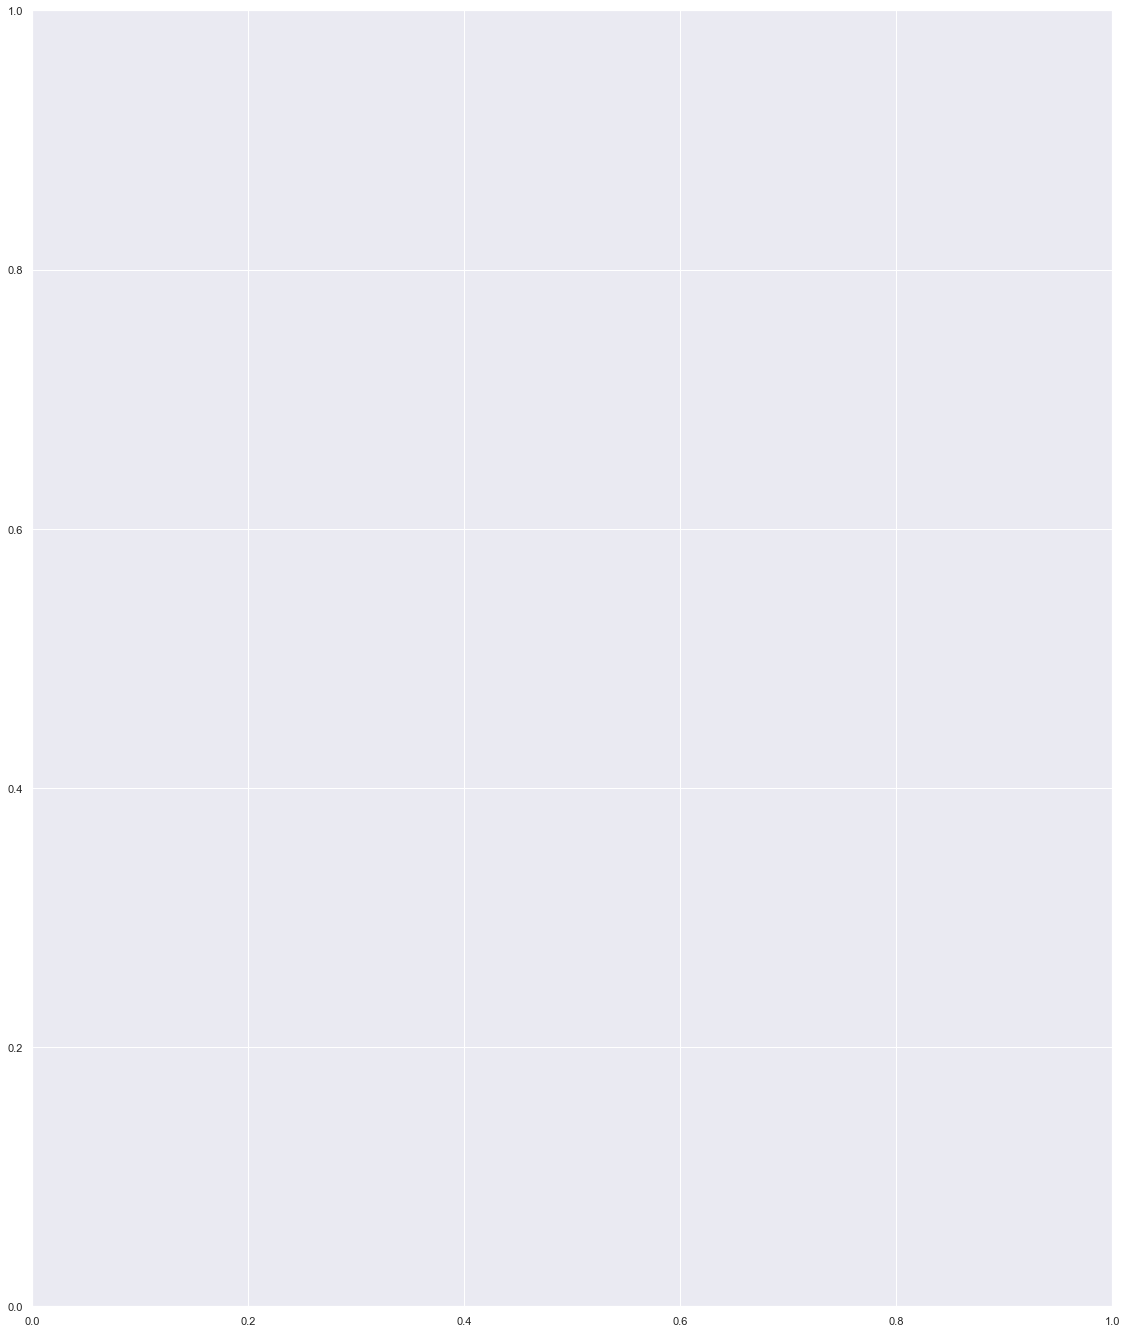

In [50]:
fig = plt.figure(figsize=(15, 18))
ax = fig.add_axes([0, 0, 1, 1])

# ax.set_xlabel('Node')
# ax.set_ylabel('Distance')

dendrogram(Z, ax=ax)
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# fig.tight_layout()

plt.show()

In [136]:
sns.reset_defaults()
cmap = cm.plasma

node_size = 50

# pos = nx.nx_agraph.graphviz_layout(Gc, prog="twopi") # dot, twopi, fdp, sfdp, circo
pos = nx.multipartite_layout(Gc, subset_key="layer", align="horizontal")


plt.figure(figsize=(15, 15))

nodes = nx.draw_networkx_nodes(
    Gc, 
    pos, 
    # nodelist=nodes_with_term,
    node_size=node_size,
    node_color='red',
    node_shape='o',
    alpha=None,
    # cmap=cmap,
    vmin=None,
    vmax=None,
    ax=None,
    linewidths=1.0, 
    edgecolors='k', 
    # label=None, 
    margins=None
)
nodes.set_zorder(1)

edges = nx.draw_networkx_edges(
    Gc, 
    pos,
    edgelist=None,
    width=1.0,
    edge_color='k',
    style='solid',
    alpha=0.5,
    arrowstyle=None,
    arrowsize=10,
    edge_cmap=None,
    edge_vmin=None,
    edge_vmax=None,
    ax=None,
    arrows=None,
    label=None,
    node_size=node_size,
    nodelist=None,
    node_shape='o',
    connectionstyle='arc3',
    min_source_margin=0,
    min_target_margin=0,
)

for c in edges:
    c.set_zorder(-1)
# edges.set_zorder(-1)

plt.legend()

plt.grid(False)
plt.box(False)

# root = root.replace('/', '-')

plt.show()
# plt.savefig(
#     os.path.join(LATEX_FIGURES_PATH, 'genealogy_trees', f'{root}.png'), 
#     transparent=True, 
#     dpi=300,
#     bbox_inches='tight',
# )

ValueError: all nodes must have subset_key (default='subset') as data

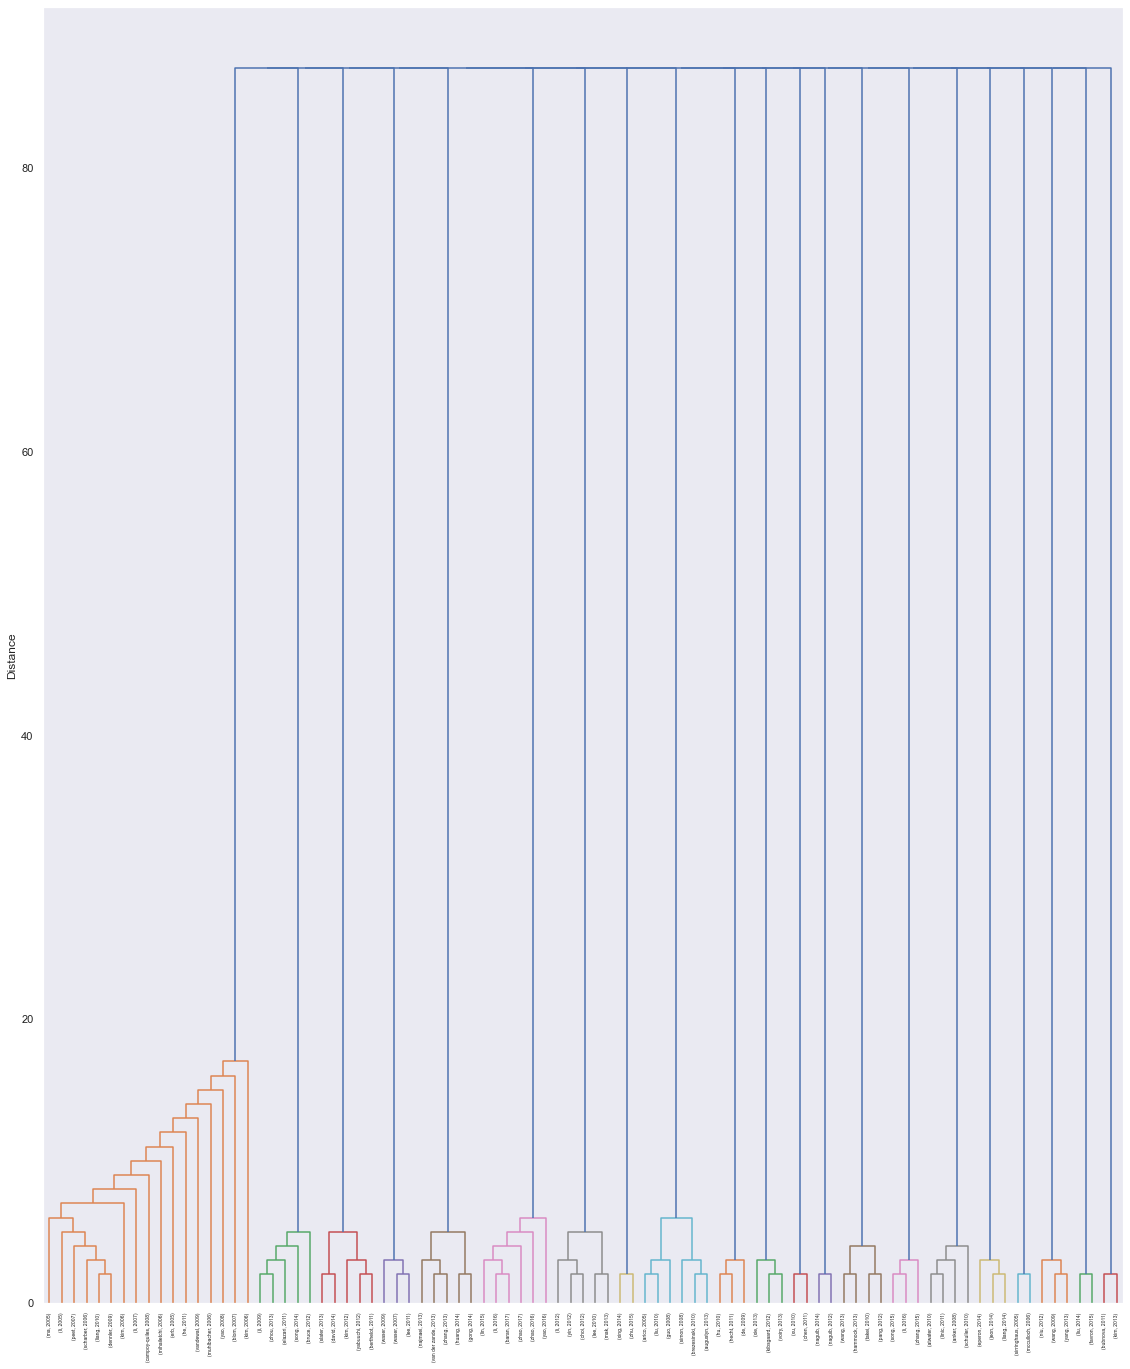

In [10]:

new_leaves = dict(
    pl.read_parquet(f'./output/main_dfs/{field_name}.parquet')
    .select(
        pl.col('Doi'), 
        pl.concat_str([
            pl.lit('('),
            pl.col('Authors').arr.first().str.split(', ').arr.first(),
            pl.lit(', '),
            pl.col('Date').dt.year(),
            pl.lit(')')
        ])
    )
    .filter(pl.col('Doi').is_in(leaves))
    .to_numpy()
)

leaves = dict(zip(leaves, leaves))
leaves.update(new_leaves)

fig = plt.figure(figsize=(15, 18))
ax = fig.add_axes([0, 0, 1, 1])

# ax.set_xlabel('Node')
ax.set_ylabel('Distance')

dendrogram(Z, labels=list(leaves.values()), ax=ax)
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# fig.tight_layout()

plt.show()

In [14]:
print(nx.number_connected_components(G))

20


In [170]:
m = nx.to_numpy_array(G)

In [171]:
Z = linkage(m, method='ward')

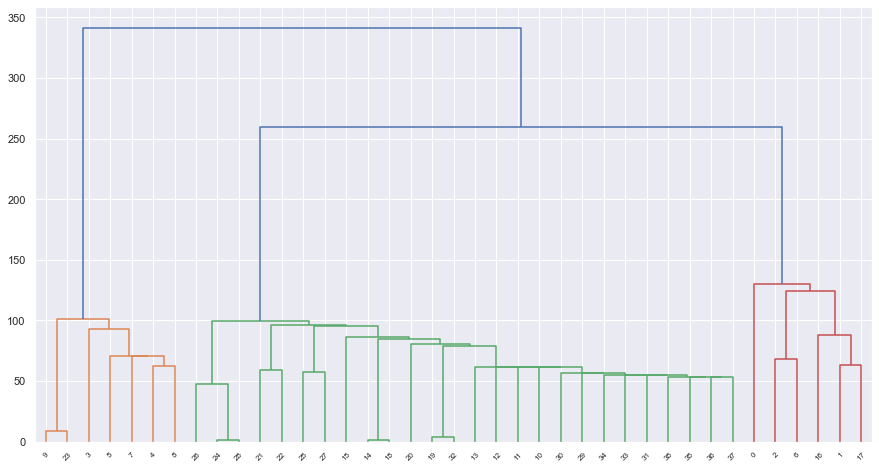

In [ ]:
dn = dendrogram(Z, labels=G.nodes)

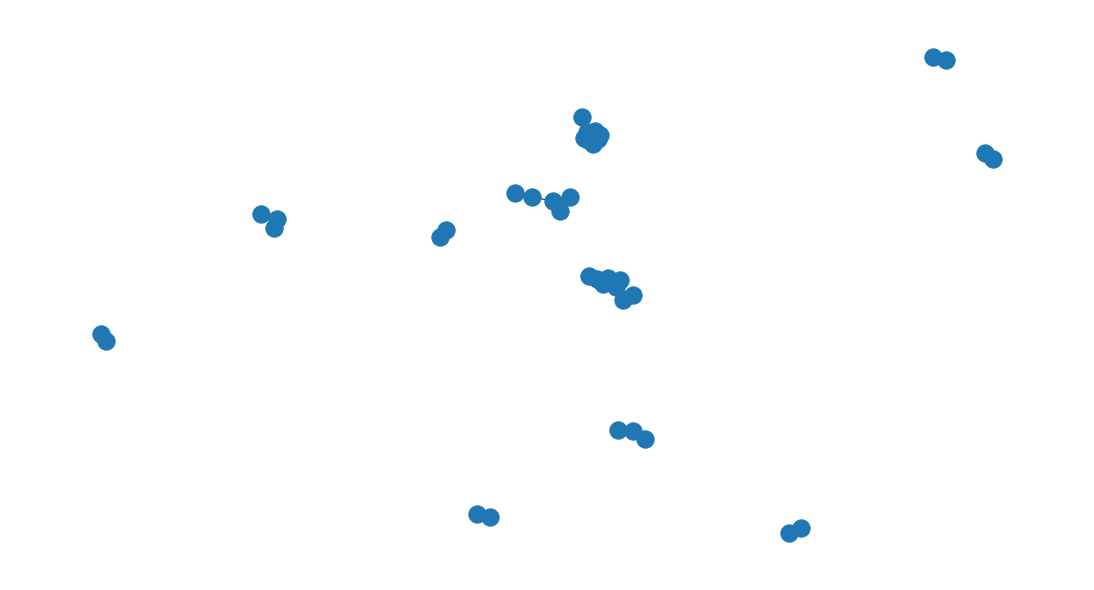

In [153]:
nx.draw(G)

In [108]:
G = Gs['Sociology']
print(G)
print(nx.number_connected_components(G))
nodes = list(G.nodes)

comms = nx.community.louvain_communities(G)
print(len(comms))

df = Dfs['Sociology']
df = df.select(pl.col('Doi'), pl.col('Text'), pl.col('References'))

labelled_comms = {}
for i, comm in enumerate(comms):
    labelled_comms.update(dict.fromkeys(comm, i))

df_comms = pl.from_dict({
    'Doi': labelled_comms.keys(),
    'Community': labelled_comms.values(),
})

df_comms = df_comms.join(df, on='Doi', how='left')

df_comms = df_comms.with_columns(pl.col('Text').arr.eval(pl.element().unique()))

df_comms = (
    df_comms
    .explode('References')
    .join(
        df_comms.select(pl.col('Doi'), pl.col('Community')),
        right_on='Doi',
        left_on='References',
        how='left',
        suffix='Reference'
    )
)

nx.set_node_attributes(G, labelled_comms, 'Community')

df_comms.head()

Graph with 2327 nodes and 21230 edges
15
27


Doi,Community,Text,References,CommunityReference
str,i64,list[str],str,i64
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.2307/209645...",0
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.1086/231084...",0
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.1146/annure...",0
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.1086/230784...",0
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.1086/230788...",0


In [125]:
df_core = (
    df_comms
    .groupby('References')
    .agg(
        pl.col('Doi'),
        pl.col('Community'),
    )
    .filter(pl.col('Community').arr.unique().arr.lengths().eq(1))
    .select(
        pl.col('References'),
        pl.lit(True).alias('Core'),
    )
)

In [135]:
dois, cores = (
    df
    .join(df_core, left_on='Doi', right_on='References', how='left')
    .fill_null(False)
    .select(
        pl.col('Doi'),
        pl.col('Core'),
    )
)

core_attrs = dict(
    zip(
        dois.to_list(),
        cores.to_list(),
    )
)

nx.set_node_attributes(G, core_attrs, 'Core')

In [ ]:
(
    df_comms
    .select(
        pl.col('Doi'),
        pl.col('Community'),
        pl.col('CommunityReference'),
    )
    .groupby(pl.col('Doi'))
    .agg(pl.all())
)

Doi,Community,CommunityReference
str,list[i64],list[i64]
"""10.1086/506413...","[7, 7, 7]","[7, 7, 7]"
"""10.1146/annure...","[1, 1, ... 1]","[1, 1, ... 1]"
"""10.1086/381914...",[6],[5]
"""10.1086/661985...","[9, 9, ... 9]","[9, 9, ... 7]"
"""10.1353/sof.20...","[5, 5, ... 5]","[5, 5, ... 5]"
"""10.2307/258035...","[1, 1, 1]","[1, 1, 1]"
"""10.1177/000312...","[5, 5, ... 5]","[5, 5, ... 5]"
"""10.1353/sof.20...","[6, 6, ... 6]","[4, 6, ... 6]"
"""10.1146/annure...","[6, 6, ... 6]","[6, 6, ... 6]"


In [73]:
nx.set_node_attributes(G, labelled_comms, 'Community')

In [68]:
df_comms.head()

Doi,Community,Text
str,i64,list[str]
"""10.2307/265733...",0,"[""variation"", ""mast"", ... ""private""]"
"""10.1086/210218...",0,"[""growth"", ""question"", ... ""rising""]"
"""10.1177/000312...",0,"[""political"", ""model"", ... ""protection""]"
"""10.1353/sof.20...",0,"[""international"", ""sense"", ... ""defining""]"
"""10.1086/649577...",0,"[""article"", ""implies"", ... ""exclusive""]"


In [72]:
(
    df_comms
    .explode('Text')
    .groupby('Text')
    .agg(pl.col('Community'))
    .filter(pl.col('Community').arr.lengths().eq(1))
    .with_columns(pl.col('Community').arr.first())
    .groupby('Community')
    .agg(pl.col('Text'))
    # .unique(subset=['Community', 'Text'])
    # .groupby('Community')
    # .agg(pl.col('Text'))
)

Community,Text
i64,list[str]
16,"[""partition"", ""goodman""]"
8,"[""antiunion"", ""nobel"", ... ""idaho""]"
0,"[""technoecology"", ""tribal"", ... ""transnationalization""]"
24,"[""assembler"", ""therapist"", ... ""retardation""]"
23,"[""overhauled"", ""deconcentration"", ... ""interactively""]"
15,"[""penalizing"", ""prwora"", ... ""diversion""]"
7,"[""deterred"", ""confounders"", ... ""externalized""]"
6,"[""postulating"", ""fun"", ... ""supervise""]"
14,"[""nonsupervisors""]"
